In [ ]:
# RUN TFLITE INFERENCE ON AN EXAMPLE DATASET

In [ ]:
!pip install tflite-runtime

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [1]:
import pandas as pd
import numpy as np


ROWS_PER_FRAME = 543 #no of landmarks per frame

def load_relevant_data_subset(pq_file):
    data_columns = ['x','y','z']
    data = pd.read_parquet(pq_file, columns = data_columns)
    n_frames = int(len(data) /ROWS_PER_FRAME)
    print(len(data))
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    print(n_frames)
    return data.astype(np.float32)

In [2]:
#load in tflite model
import tensorflow as tf
# import tflite_runtime.interpreter as tflite

interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()
# interpreter = tflite.Interpreter("./model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

# output = prediction_fn(inputs=demo_raw_data)
# sign = output['outputs'].argmax()

In [4]:
train = pd.read_csv('../train_new_csv.csv')
train['sign_ord'] = train['sign'].astype('category').cat.codes
# print(train['sign_ord'])
#dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

pq_file = './output.parquet'
xyz_np = load_relevant_data_subset(pq_file)
prediction = prediction_fn(inputs = xyz_np)
sign = prediction['outputs'].argmax() 
print(prediction['outputs'])
# print(sign)



10860
20
[0.00136816 0.00123209 0.00285699 0.00425927 0.00246963 0.00188843
 0.00201443 0.0015669  0.00433541 0.00288039 0.00195571 0.00148852
 0.00337814 0.00733181 0.00261543 0.00212885 0.00190779 0.03089553
 0.0066126  0.0016906  0.00393243 0.00182378 0.00346618 0.00225523
 0.0031589  0.00224078 0.01500261 0.00075181 0.0044936  0.01609512
 0.00151842 0.02095075 0.00234253 0.00085169 0.00304423 0.00341299
 0.00341685 0.00171457 0.00177249 0.00361401 0.00501855 0.00210719
 0.00082132 0.00126179 0.00173155 0.00105947 0.00247779 0.00468469
 0.00347434 0.00778623 0.00316574 0.01161564 0.00203883 0.00232705
 0.00294234 0.00195887 0.00127393 0.00445315 0.0104315  0.00632062
 0.00334321 0.00208569 0.00338903 0.00571801 0.00084072 0.00262323
 0.00350158 0.00408443 0.00073001 0.00052098 0.00530435 0.00307587
 0.00256951 0.00142762 0.005033   0.00666718 0.00350229 0.00570196
 0.00313306 0.00297717 0.00106001 0.00313021 0.02729697 0.00290652
 0.00368032 0.00075568 0.00446002 0.00165889 0.002518

In [5]:
train['sign_ord'].max()

1

In [6]:
print(ORD2SIGN)

{1: 'thankyou', 0: 'hello'}


In [7]:
if (sign==113):
    sign = 0
elif(sign==214):
    sign = 1

In [8]:
ORD2SIGN[sign]

'hello'

In [17]:
prediction

{'outputs': array([1.3063436e-03, 1.2468476e-03, 1.0713328e-03, 2.4337666e-03,
        1.2293204e-03, 1.3713734e-03, 6.7790766e-04, 1.8261095e-03,
        7.8885333e-04, 1.2953996e-03, 1.7443073e-03, 9.3403534e-04,
        1.6086806e-03, 1.0538215e-03, 9.7114488e-04, 1.2677652e-03,
        8.0163020e-04, 5.4352864e-04, 4.7006086e-03, 4.2484724e-04,
        6.2008220e-04, 9.1068284e-04, 1.0841419e-03, 8.8719133e-04,
        9.9764974e-04, 1.1498729e-03, 7.7999276e-03, 1.3455490e-03,
        4.8511746e-04, 7.5630023e-04, 1.4482553e-03, 2.2237257e-03,
        1.5848123e-03, 4.8301075e-04, 1.1672024e-03, 1.0001428e-03,
        1.6609222e-03, 7.1059901e-04, 8.8350201e-04, 7.5023796e-04,
        9.6128864e-04, 9.8941685e-04, 7.4675481e-04, 1.3333830e-03,
        1.5444556e-03, 1.4942626e-03, 3.2501994e-03, 1.8264805e-03,
        5.1988335e-04, 1.1320129e-03, 1.7160568e-03, 1.0762940e-03,
        1.1771065e-03, 9.2762208e-04, 1.8702872e-03, 7.9751370e-04,
        1.0587076e-03, 1.1723117e-03,

In [20]:
prediction['outputs'].shape

(250,)

<Axes: >

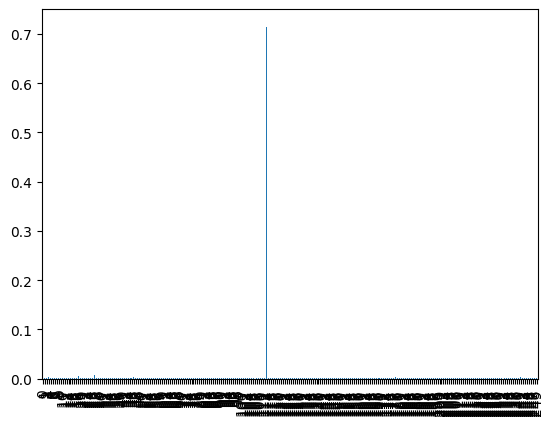

In [23]:
pd.Series(prediction['outputs']).plot(kind='bar')